# Задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

In [5]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


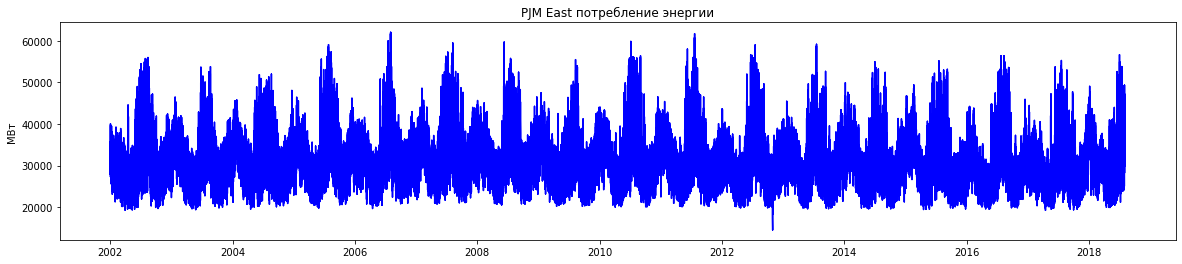

In [8]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [9]:
e_ar = data['PJME_MW'].values
e_s = pd.DataFrame(data = data['PJME_MW'])
e_s.head()

,PJME_MW
Date,
2002-01-01,30393.0
2002-01-01,29265.0
2002-01-01,28357.0
2002-01-01,27899.0
2002-01-01,28057.0


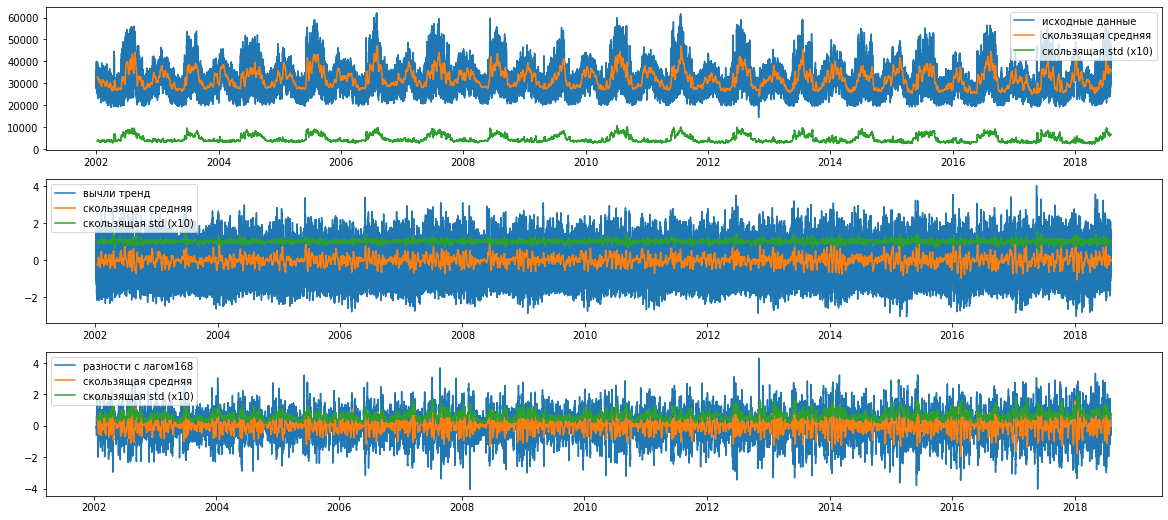

In [12]:
#import matplotlib.dates as mdates
train = e_s.iloc[:-10, :]
test = e_s.iloc[-10:, :]


N2 = 24*7

e_s['z_data'] = (e_s['PJME_MW'] - e_s['PJME_MW'].rolling(window=N2).mean()) / e_s['PJME_MW'].rolling(window=N2).std()
e_s['zp_data'] = e_s['z_data'] - e_s['z_data'].shift(N2)

def plot_rolling(b_s):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(b_s.index, b_s['PJME_MW'], label='исходные данные')
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(b_s.index,b_s.z_data, label="вычли тренд")
    ax[1].plot(b_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(b_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(b_s.index, b_s.zp_data, label="разности с лагом" +str(N2))
    ax[2].plot(b_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(b_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(e_s)    

Text(0.5, 1.0, 'PJME_MW')

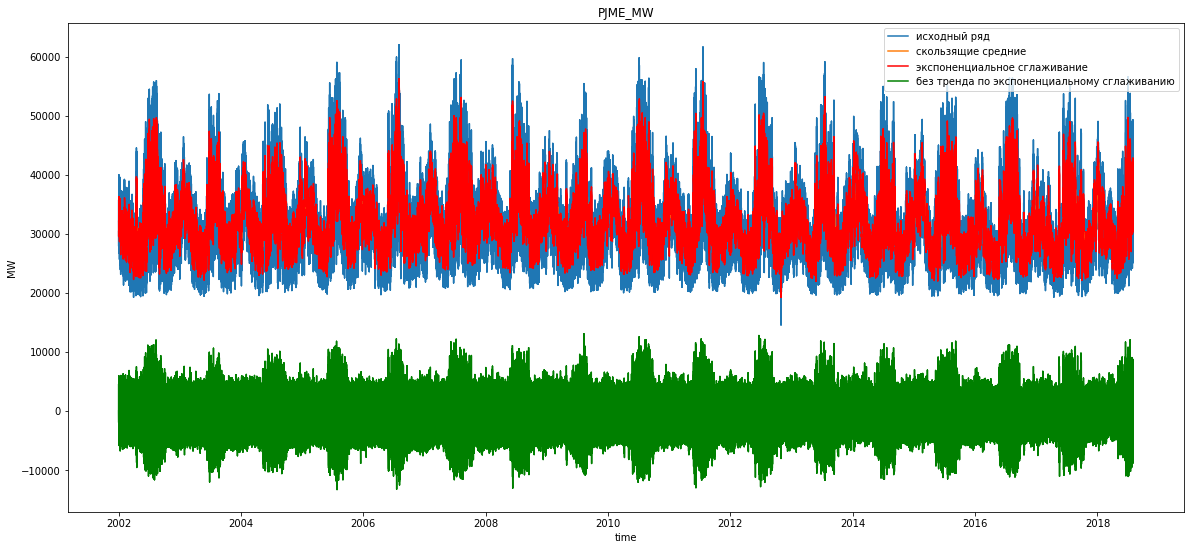

In [17]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

e_ar_exp_1 = exponential_smoothing(data['PJME_MW'], 0.1)

plt.figure(figsize=(20, 9))
plt.plot(e_s.index, e_s['PJME_MW'], label='исходный ряд')
plt.plot(e_s['PJME_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(e_s.index,e_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(e_s.index,e_s['PJME_MW'] - e_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [18]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [20]:
e_ar_exp_1 = pd.DataFrame(data = e_ar_exp_1, index = e_s.index)
#без тренда 
energy_data_trend_free = (e_s['PJME_MW'] - e_ar_exp_1.iloc[:,0])
energy_data_trend_free.head()
DF_energy = sm.tsa.stattools.adfuller(energy_data_trend_free , regression = 'ctt')
DF_energy

(-52.88796448855074,
 0.0,
 75,
 145298,
 {'1%': -4.371209756407774,
  '5%': -3.8324306460238056,
  '10%': -3.553285187108092},
 2061681.9853488158)

In [22]:
DF_energy[1] == 0

True

Text(0.5, 1.0, 'PJME_MW')

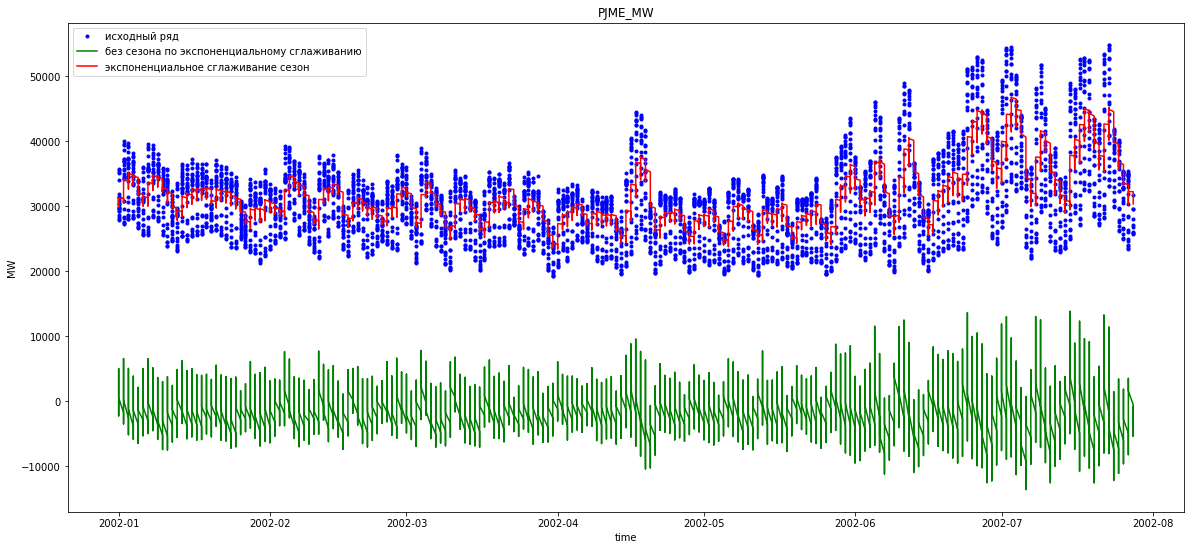

In [27]:
data_exp_1 = exponential_smoothing(data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(data.index[:5000], data['PJME_MW'].values[:5000], '.b',label='исходный ряд')

plt.plot(data.index[:5000],data['PJME_MW'].values[:5000] - data_exp_1[:5000] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(data.index[:5000],data_exp_1[:5000] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

Text(0.5, 1.0, 'PJME_MW')

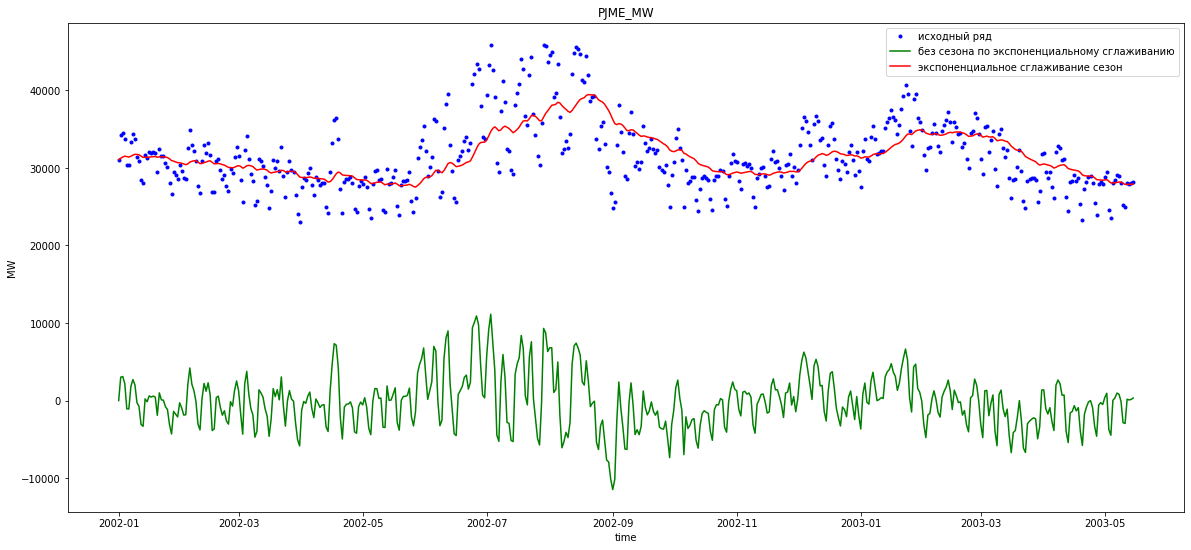

In [29]:
d_data=data.resample('D').mean()
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [30]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.365362138569354,
 4.282974615216728e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

In [32]:
df= pd.DataFrame(e_ar_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=1)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,30393.0000,0.000,0.00,0.0,30393.000000,30393.000000,30393.000000,0.0000
2002-01-01,30280.2000,30393.000,0.00,0.0,30391.872000,30389.616000,30383.976000,112.8000
2002-01-01,30087.8800,30280.200,30393.00,0.0,30388.832080,30380.563920,30360.288320,192.3200
2002-01-01,29868.9920,30087.880,30280.20,30393.0,30383.633679,30365.216762,30320.984614,218.8880
2002-01-01,29687.7928,29868.992,30087.88,30280.2,30376.675270,30344.894044,30270.329269,181.1992


In [33]:
df.columns

Index([0, 't', 't1', 't2', 'exp_0_01', 'exp_0_03', 'exp_0_08', 'diff1'], dtype='object')

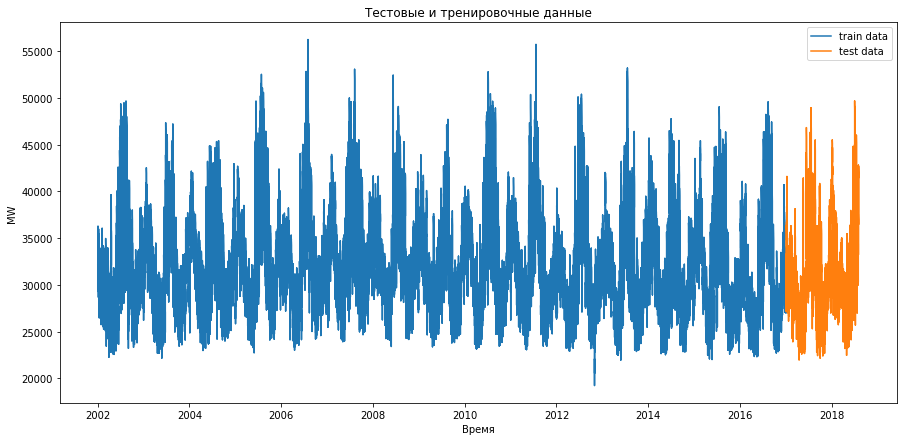

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df, '01-01-2017')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

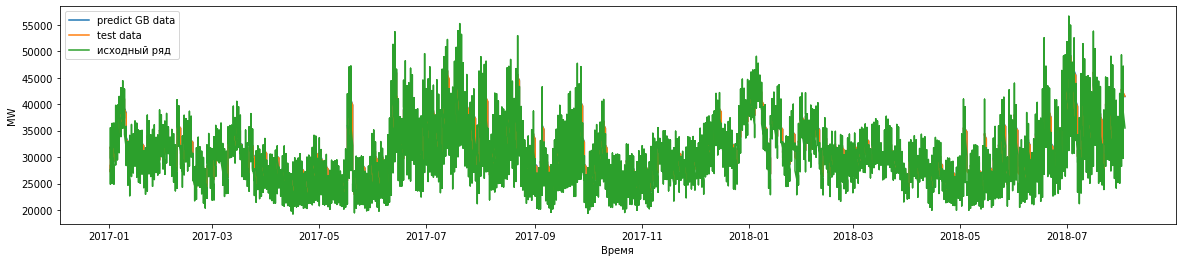

ошибка градиентного бустинга :   0.16911770516217461 %


In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(e_s.loc['2017-01-02':].index, e_s.loc['2017-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

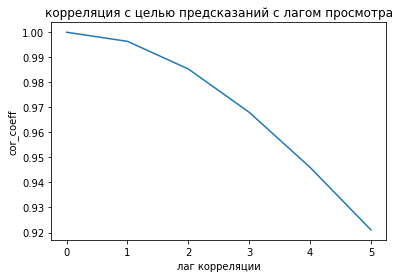

In [42]:
lag=5
p_cor=[np.corrcoef( y_test_b, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

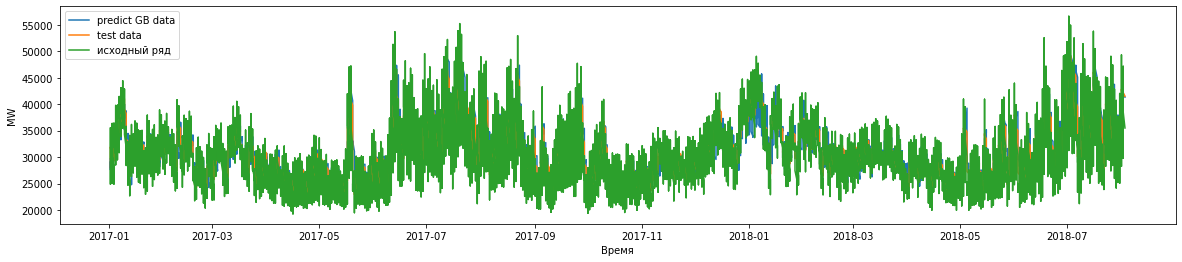

ошибка градиентного бустинга :   4.857551589454211 %


In [43]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('MW')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(e_s.loc['2017-01-02':].index, e_s.loc['2017-01-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')


2. Оцените ошибки моделей из п.1 .

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Ошибка с горизонтом 1 - 0,17% работает отлично, с горизонтом 10 - 4,86% предсказываем значительно хуже

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :). стационарный, с трендом(на интервалах времен суток, на полугодовых интервалах), с сезонностиь на годовых интервалах, цикличны в рамках дня/года
    
    б) Количество денег, которые тратят покупатели в интернет магазине. Стационарный при неизменных условиях(ЗП/стабильность валюты). Тренд из-за инфляции
    
    в) Вес растущего котенка. Не стационарный, с трендом
    
    г) Прирост объема деревьев в лесу от времени. Не стационарный, с трендом, возможны циклы на фоне солнечной активности